### Setup

In [1]:
# Mount your google drive. This will launch a pop-up window for authentication.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#cd your_path_here
%cd "/content/drive/Shareddrives/ES143/Final_Project"

/content/drive/Shareddrives/ES143/Final_Project


In [3]:
!pip install opencv-python
!pip install opencv-python-headless
!pip install numpy
%pip install pyheif pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 26.9 MB/s eta 0:00:00


In [4]:
# Import required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import os
import requests
import pickle
import glob   # filename and path management for file I/O
import plotly.express as px
import plotly.graph_objects as go

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

import os
import pyheif
from PIL import Image

from scipy.optimize import least_squares
import scipy.interpolate

In [5]:
#@title helper functions: `in2hom()`, `hom2in()`, `normalizing_transform()`

def in2hom(X):
    """
    Convert from inhomogeneous to homogeneous coordinates

    Args:
      X  - NxD numpy array, tyically with D=2 (rows (x,y)) or D=3 (rows (x,y,z))

    Returns:
      Xh - Nx(D+1) numpy array with an appended column of ones
    """

    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from homogeneous to inhomogeneous coordinates
def hom2in(Xh):
    """
    Convert from homogeneous to inhomogeneous coordinates

    Args:
      Xh  - Nx(D+1) numpy array, tyically with D=2 (rows (x,y,w)) or D=3 (rows (x,y,z,w))

    Returns:
      X - NxD numpy array with the first D columns divided by column (D+1)
    """

    return Xh[:, :2] / Xh[:, 2:]

def normalizing_transform(X):
    """
    Compute a (Dx1)x(Dx1) normalizing transformation from N points in D dimensions

    Args:
      X - NxD numpy array, tyically with D=2 (rows (x,y)) or D=3 (rows (x,y,z))

    Returns:
      T - a (D+1)x(D+1) matrix that normalizes the points to be centered at their
          centroid, with average distance equal to sqrt(D)
    """

    # dimension of datapoints
    D = X.shape[1]

    # Compute centroid
    centroid = X.mean(axis=0, keepdims=True)

    # Compute the denominator of scale factor s
    denom = np.mean(np.sqrt(np.sum((X - centroid) ** 2, axis=1)))

    # Compute s, tx, ty
    s = np.sqrt(D) / denom
    t = -s * centroid[0, :]
    t = np.concatenate((t,np.array([1])))

    # return matrix T
    return np.concatenate((s*np.eye(D+1,D+1)[:,0:D], np.expand_dims(t,1)),axis=1)


### Load Dataset

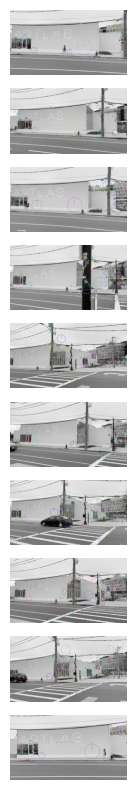

In [28]:
# Path to the image folder
folder_path = '/content/drive/Shareddrives/ES143/Final_Project/dataset/artlab/'

sift = cv2.SIFT_create()

output_images = []

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        file_path = os.path.join(folder_path, filename)

        im = cv2.imread(file_path)

        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        keypoints, descriptors = sift.detectAndCompute(gray, None)

        imKeypoints = cv2.drawKeypoints(gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        output_images.append(imKeypoints)

        # Optionally, save or display the image
        # cv2.imwrite(f'output_keypoints_{filename}', imKeypoints)  # Save the keypoints image

# Display the images
# fig, axes = plt.subplots(len(output_images), 1, figsize=(10, 10))
# for ax, img in zip(axes, output_images):
#     ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert color space for plotting
#     ax.axis('off')
# plt.show()

### Detect features and find matches

In [38]:
def load_images_from_folder(folder):
    """Loads all images in the specified folder and returns a list of images and their paths."""
    images = []
    paths = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
                paths.append(os.path.join(folder, filename))
    return images, paths

def find_matches(keypoints1, keypoints2, descriptors1, descriptors2, percentage=25):
    """Finds and returns the top 'percentage' percentile matches between two images."""
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    num_good_matches = int(len(matches) * (percentage / 100))
    good_matches = matches[:num_good_matches]
    return good_matches

def process_images(images):
    """Processes a list of images to find SIFT keypoints and descriptors for each."""
    sift = cv2.SIFT_create()
    keypoints_all = []
    descriptors_all = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        keypoints_all.append(keypoints)
        descriptors_all.append(descriptors)
    return keypoints_all, descriptors_all

In [39]:
def find_all_matches(keypoints_all, descriptors_all):
    """Finds and returns the matches between selected pairs of images using their descriptors."""
    bf = cv2.BFMatcher()
    all_matches = []
    num_images = len(descriptors_all)
    for i in range(num_images):
        for j in range(i + 1, num_images):
            matches = bf.knnMatch(descriptors_all[i], descriptors_all[j], k=2)
            good = [m for m, n in matches if m.distance < 0.75 * n.distance]
            all_matches.append((i, j, good))
    return all_matches

In [40]:
images, image_paths = load_images_from_folder(folder_path)

# Compute keypoints and descriptors
keypoints_all, descriptors_all = process_images(images)

results = []
for i in range(1, len(images)):
    matches = find_matches(keypoints_all[0], keypoints_all[i], descriptors_all[0], descriptors_all[i], 25)
    img_matches = cv2.drawMatches(images[0], keypoints_all[0], images[i], keypoints_all[i], matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    results.append(img_matches)

# Displaying all matches
for result in results:
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Estimate homography using matched feature points

In [10]:
def getH(X1, X2):

    assert np.all(X1.shape == X2.shape), "X1 and X2 must have the same shape"
    assert X1.shape[1] == 2, "X1 and X2 must have 2 columns (but they have {} columns)".format(X1.shape[1])

    numpts = X1.shape[0]

    # compute normalizing transform for each set of points
    T1 = normalizing_transform(X1)
    T2 = normalizing_transform(X2)

    # apply normalizations
    # (note that X*T' = (T*X')', where ' denotes the transpose operator)
    X1h = in2hom(X1).dot(T1.transpose())
    X2h = in2hom(X2).dot(T2.transpose())

    # TO DO: Replace the following line with code that:
    #  (a) constructs a (numpts)x9 matrix A for the homogeneous linear system
    A = np.zeros((2*numpts, 9))
    for i in range(numpts):
        x1, y1, w1 = X1h[i, 0], X1h[i, 1], X1h[i, 2]
        x2, y2, w2 = X2h[i, 0], X2h[i, 1], X2h[i, 2]
        A[2*i] = [x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2]
        A[2*i+1] = [0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2]

    #  (b) computes the SVD and extracts the smallest right singular vector
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1]

    #  (c) properly reshapes that singular vector into a 3x3 homography matrix
    H = h.reshape(3, 3)

    invT2H, _, _, _ = np.linalg.lstsq(T2, H, rcond=None)
    Hout = invT2H.dot(T1)

    return Hout

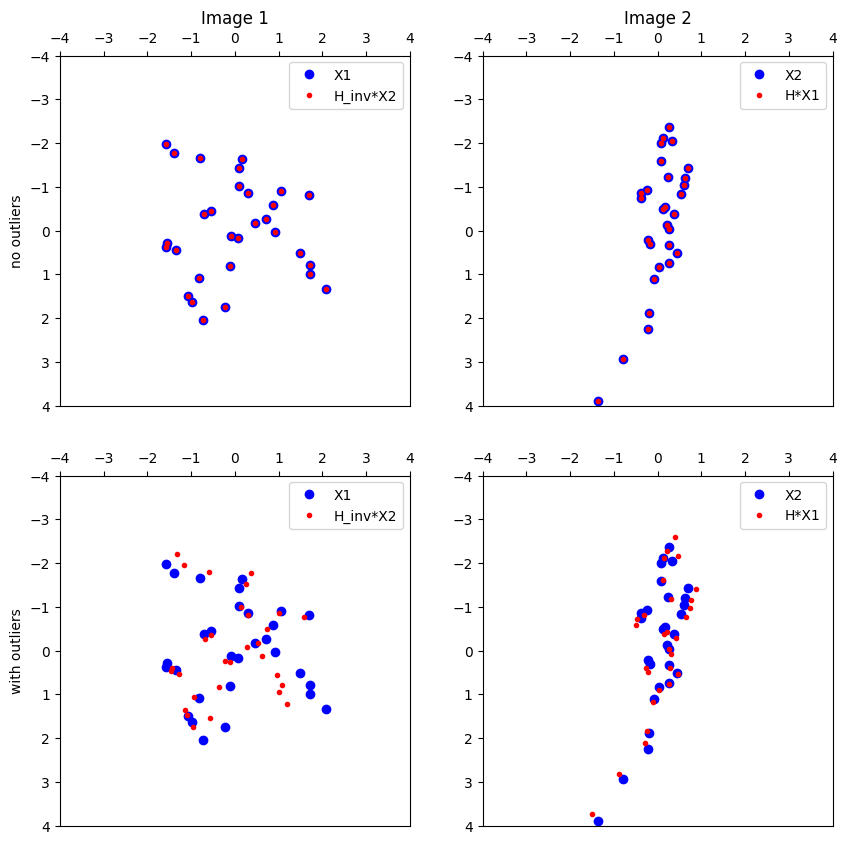

In [11]:
def generate_homography_test_data(numpts):
    """
    Randomly generate a homography along with points X1 and X2 that satisfy X2=H*X1

    Args:
      numpts = number of points in X1, X2

    Returns:
      X1    - Nx2 numpy array of inhomogeneous 2D points, with rows (x,y)
      X2    - Nx2 numpy array of inhomogeneous 2D points, with rows (x,y)
      H     - 3x3 homography that maps points in X1 to points in X2
    """

    # generate random points X1
    X1 = np.random.rand(numpts, 2)

    # generate a random 3x3 homography
    H = np.reshape(np.random.rand(9),(3,3))

    # compute X2 (note that X*H' = (H*X')' where ' is transpose operator)
    X2 = hom2in( in2hom(X1).dot( H.T ) )

    # transform the point-sets to have coordinates in range [-axlim, axlim]
    T1 = normalizing_transform(X1)
    T2 = normalizing_transform(X2)
    X1 = hom2in(in2hom(X1).dot(T1.T))
    X2 = hom2in(in2hom(X2).dot(T2.T))

    # adjust the homography to incorporate these transformations
    H = T2 @ H @ np.linalg.inv(T1)

    return X1, X2, H

def plotH(X1, X2, H, axlim, ax1=None, ax2=None):
    """
    Plot points X1, X2 and their homography-mapped counterparts, H*X1 and inv(H)*X2

    Args:
      X1    - Nx2 numpy array of inhomogeneous 2D points, with rows (x,y)
      X2    - Nx2 numpy array of inhomogeneous 2D points, with rows (x,y)
      H     - 3x3 homography that maps points in X1 to points in X2
      axlim - limits of axes (-axlim, +axlim)
      ax1   - matplotlib axes object (optional)
      ax2   - matplotlib axes object (optional)

    Returns:
      fig - matplotlib figure object
      ax1 - matplotlib axes object
      ax2 - matplotlib axes object
    """

    if ax1 is None or ax2 is None:
        # Create new axes if not provided
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    else:
        # Use provided axes
        fig = ax1.figure

    # Map points using the estimated homography:
    X1_mapped = np.dot(np.hstack((X1, np.ones((X1.shape[0], 1)))), H.T)
    X1_mapped = X1_mapped[:, :2] / X1_mapped[:, 2][:, None]

    X2_mapped = np.linalg.lstsq(H, np.hstack((X2, np.ones((X2.shape[0], 1)))).T, rcond=None)[0].T
    X2_mapped = X2_mapped[:, :2] / X2_mapped[:, 2][:, None]

    # plot input points
    ax1.plot(X1[:, 0], X1[:, 1], 'b.', markersize=12, label='X1')
    ax2.plot(X2[:, 0], X2[:, 1], 'b.', markersize=12, label='X2')

    # plot points mapped by estimated homography and its inverse
    ax1.plot(X2_mapped[:, 0], X2_mapped[:, 1], 'r.', markersize=6, label='H_inv*X2')
    ax2.plot(X1_mapped[:, 0], X1_mapped[:, 1], 'r.', markersize=6, label='H*X1')

    ax1.legend()
    ax2.legend()

    # make axes "image-like", with origin (0,0) in the top-left corner
    for ax in [ax1, ax2]:
        ax.set_aspect(aspect=1)
        ax.set_xlim([-axlim, axlim])
        ax.set_ylim([-axlim, axlim])
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    return fig, ax1, ax2

# test data parameters
num_inliers = 30  # number of points in X1 (and X2) that are exactly explained by H
num_outliers = 5  # number of random outlier points, not explained by H
axlim = 4         # gnerated x,y coordinates are in range [-axlim, axlim]

# generate test data
X1,X2,H = generate_homography_test_data(num_inliers)

# generate some random outliers and mix them with the inliers
X1out = axlim*(np.random.rand(num_outliers, 2) - 0.5)
X2out = axlim*(np.random.rand(num_outliers, 2) - 0.5)
X1out = np.vstack((X1,X1out))
X2out = np.vstack((X2,X2out))

# estimate homography using clean data, without outliers
H_est_clean = getH(X1, X2)

# estimate homography again with outliers
H_est_with_outliers = getH(X1out, X2out)

# plot the results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

plotH(X1, X2, H_est_clean, axlim, ax1, ax2)
plotH(X1, X2, H_est_with_outliers, axlim, ax3, ax4)

ax1.set_ylabel('no outliers')
ax3.set_ylabel('with outliers')
ax1.set_title('Image 1')
ax2.set_title('Image 2')

plt.show()

In [12]:
def getH_ransac(X1, X2, threshold, num_iters):

    assert X1.shape[1] == 2, "X1 must have 2 columns (but it has {} columns)".format(X1.shape[1])
    assert X1.shape[0] == X2.shape[0], "X1 and X2 must have the same number of rows"

    numpts = X1.shape[0] # number of correspondences

    best_consensus = np.zeros((1,))  # Initialize as zeros so its sum is zero
    for i in range(num_iters):

        # Randomly select 4 correspondences
        ind = np.random.choice(np.arange(numpts), size=4, replace=False)

        # Get homography between the 4 point pairs
        H = getH(X1[ind, :], X2[ind, :])

        # Apply H to X1 to get an estimate of X2
        X2_est = hom2in(in2hom(X1).dot(H.transpose()))

        # Apply inv(H) to X2 to get an estimate of X1.
        # As usual, use numpy.linalg.lstsq() instead of inv().
        X1h_est, _, _, _ = np.linalg.lstsq(H, in2hom(X2).transpose(), rcond=None)
        X1_est = hom2in(X1h_est.transpose())

        # TO DO: replace the following line to compute symmetric transfer distances using homography H
        #   - your code should produce a vector of numpts elements, where the i'th
        #     element is the symmetric transfer distance between X1[j,:] and X2[j,:]
        #   - you should do this without a loop
        distances = np.sqrt(np.sum((X2 - X2_est)**2, axis=1) + np.sum((X1 - X1_est)**2, axis=1))

        # Find consensus set: Produce a binary vector of length N, where distance[j]==1
        # indicates that the j-th correspondence X1[j,:] <-> X2[j,:] is in
        # the consensus set
        consensus = (distances < threshold)

        # If size of consensus set is largest so far, use it
        if sum(consensus) > sum(best_consensus):
            best_consensus = consensus

    # Use the largest consensus set to get final least-squares estimate of homographys
    return getH(X1[best_consensus, :], X2[best_consensus, :]), best_consensus

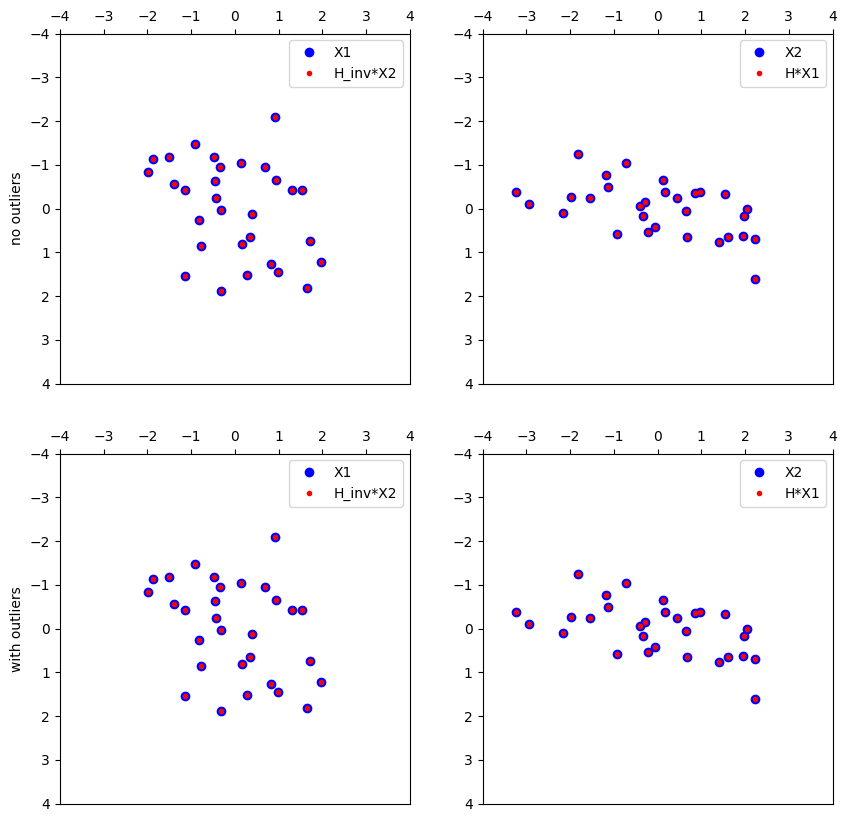

In [13]:
#@title test script for getH_ransac()

# TO DO: set your RANSAC parameters here
ransac_threshold = 0.1
ransac_numiterations = 100

# test data parameters
num_inliers = 30  # number of points in X1 (and X2) that are exactly explained by H
num_outliers = 5  # number of random outlier points, not explained by H
axlim = 4         # generated x,y coordinates are in range [-axlim, axlim]

# generate test data
X1,X2,H = generate_homography_test_data(num_inliers)

# generate some random outliers and mix them with the inliers
X1out = axlim*(np.random.rand(num_outliers, 2) - 0.5)
X2out = axlim*(np.random.rand(num_outliers, 2) - 0.5)
X1out = np.vstack((X1,X1out))
X2out = np.vstack((X2,X2out))

# estimate homography using clean data, without outliers
H_est_clean,_ = getH_ransac(X1, X2, ransac_threshold, ransac_numiterations)

# estimate homography again with outliers
H_est_with_outliers,_ = getH_ransac(X1out, X2out, ransac_threshold, ransac_numiterations)

# plot the results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

plotH(X1, X2, H_est_clean, axlim, ax1, ax2)
ax1.set_ylabel('no outliers')

plotH(X1, X2, H_est_with_outliers, axlim, ax3, ax4)
ax3.set_ylabel('with outliers')

plt.show()

### Calibrate camera

In [41]:
def get_calibration_points(keypoints_all, all_matches):
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane

    for (i, j, matches) in all_matches:
        if matches:
            objp = np.zeros((len(matches), 3), np.float32)
            objp[:, :2] = np.random.rand(len(matches), 2) * 100  # dummy object points, not ideal for real calibration

            imgp1 = np.array([keypoints_all[i][m.queryIdx].pt for m in matches], dtype=np.float32)
            imgp2 = np.array([keypoints_all[j][m.trainIdx].pt for m in matches], dtype=np.float32)

            # Append to corresponding lists
            objpoints.append(objp)
            imgpoints.append(imgp1)  # Assuming the points in the first image are the image points

    return objpoints, imgpoints

In [42]:
def calibrate_camera(objpoints, imgpoints, image_size):
    """Calibrates camera given sets of object points and image points."""
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    return ret, mtx, dist, rvecs, tvecs

In [43]:
# Find good matches between all pairs of images
all_matches = find_all_matches(keypoints_all, descriptors_all)

# Get 3D-2D points correspondence
objpoints, imgpoints = get_calibration_points(keypoints_all, all_matches)

# Assuming the object points are the same for all images (adjust accordingly)
image_size = (images[0].shape[1], images[0].shape[0])

# Camera calibration
ret, mtx, dist, rvecs, tvecs = calibrate_camera(objpoints, imgpoints, image_size)

# Undistort an image
h, w = images[0].shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
dst = cv2.undistort(images[0], mtx, dist, None, newcameramtx)

In [45]:
print("Reprojection Error:", ret)
print("Intrinsic Matrix:\n", mtx)
print("Distortion Coefficients:\n", dist)
# print("Rotation Vectors:\n", rvecs)
# print("Translation Vectors:\n", tvecs)

Reprojection Error: 380.6006636167036
Intrinsic Matrix:
 [[ 53.04116069   0.         499.50000008]
 [  0.          37.29599497 280.49999986]
 [  0.           0.           1.        ]]
Distortion Coefficients:
 [[-1.43197453e-07 -1.90532151e-07  3.13979365e-07  3.23348387e-06
   2.26811770e-11]]
